### Word2vec+CNN Text Classification


In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.cluster import KMeans
import contractions
from unidecode import unidecode

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import nltk.corpus
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
from wordcloud import WordCloud

import gensim
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from sklearn.model_selection import train_test_split
import tensorflow as tf

[nltk_data] Downloading package punkt to /Users/sruthipg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sruthipg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sruthipg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
data = pd.read_csv("/Users/sruthipg/Documents/Twitter/CA_2/twitter_data.csv", header=None)
data.shape

(1600000, 6)

In [7]:
headers = ['sentiment', "ids", "date", "flag", "user", "tweets"]
data.columns = headers

In [8]:
dataset = data[['sentiment','tweets']]

In [9]:
dataset.loc[dataset['sentiment'] == 4, 'sentiment'] = 1

In [10]:
dataset.loc[dataset['sentiment'] == 4, 'sentiment'] = 1

In [11]:
contractions = pd.read_csv('/Users/sruthipg/Documents/Twitter/CA_2/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [12]:
urlPattern        = r"(http://[^ ]*|https://[^ ]*|www\.[^ ]*)"
userPattern       = r'@[^\s]+'
alphaPattern      = r"[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"
pattern = r'<[^>]*>'

In [13]:
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)
    tweet = re.sub(pattern, '', tweet)
    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [14]:
dataset['processed_text'] = dataset['tweets'].apply(preprocess_apply)

/var/folders/pr/r04ldkqs0n97bc0r__zf7t700000gn/T/ipykernel_18993/4286208092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['processed_text'] = dataset['tweets'].apply(preprocess_apply)


In [15]:
language = 'english'

In [16]:
dataset['processed_text'].dropna()

0              aww  thatis a bummer   you shoulda got dav...
1          is upset that he cannot update his facebook by...
2           i dived many times for the ball  managed to s...
3            my whole body feels itchy and like its on fire 
4           no  it is not behaving at all  i am mad  why ...
                                 ...                        
1599995    just woke up  having no school is the best fee...
1599996    thewdb com   very cool to hear old walt interv...
1599997    are you ready for your mojo makeover  ask me f...
1599998    happy 38th birthday to my boo of all time   tu...
1599999                            happy  charitytuesday    
Name: processed_text, Length: 1600000, dtype: object

In [17]:
corpus = dataset['processed_text'].tolist()

In [18]:
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

In [19]:
def twoLetters(listOfTokens):
    twoLetterWord = []  # Initialize an empty list to store tokens that meet the conditions
    for token in listOfTokens:  # Iterate over each token in the input list
        if len(token) <= 2 or len(token) >= 21:  # Check if the length of the token satisfies the conditions
            twoLetterWord.append(token)  # If the condition is met, add the token to the list
    return twoLetterWord 

In [20]:
def gensim_lemmatizer(text, stop_words):
    lemmatizer = WordNetLemmatizer()  # Initialize WordNetLemmatizer
    return [lemmatizer.lemmatize(word) for word in text if word not in stop_words]

In [21]:
def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    processed_corpus = []
    for document in corpus:
        document = document.replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        document = document.replace(',', '')          # Removes commas
        document = document.rstrip('\n')              # Removes line breaks
        document = document.casefold()                # Makes all letters lowercase
        document = re.sub(r'[^a-zA-Z\s]', '', document)

        document = re.sub('\W_',' ', document)        # removes specials characters and leaves only words
        document = re.sub("\S*\d\S*"," ", document)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        document = re.sub("\S*@\S*\s?"," ", document) # removes emails and mentions (words with @)
        document = re.sub(r'http\S+', '', document)   # removes URLs with http
        document = re.sub(r'www\S+', '', document)    # removes URLs with www


        listOfTokens = word_tokenize(document) # It tokenizes the processed document.
        twoLetterWord = twoLetters(listOfTokens) # It identifies and removes two-letter words.

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = gensim_lemmatizer(listOfTokens, stopwords) # It removes stopwords and lemmatizes the remaining tokens.
        processed_document = " ".join(listOfTokens)
        processed_document = unidecode(processed_document)  # Apply unidecode to the processed document string
        processed_corpus.append(processed_document)

    return processed_corpus

In [23]:
corpus = processCorpus(corpus, language)

In [24]:
tokenized_corpus = [sentence.split() for sentence in corpus]

In [25]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [26]:
model = Word2Vec(tokenized_corpus, min_count=1, workers=cores-1, sg=1,vector_size=500)
model.save('word2vec.model')

In [28]:
vector_model = Word2Vec.load("/Users/sruthipg/Documents/Twitter/CA_2/word2vec.model")

In [29]:
print(vector_model)
print(vector_model.wv.vector_size)
vocab_size = len(vector_model.wv)
vocab_size

Word2Vec<vocab=245201, vector_size=500, alpha=0.025>
500


245201

In [30]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [31]:
df = pd.DataFrame({'Message': tokenized_corpus})
token = Tokenizer(num_words=vocab_size)
sentences = df['Message'].apply(lambda x: ' '.join(x))
token.fit_on_texts(sentences)
sequences = token.texts_to_sequences(sentences)
max_sequence_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [62]:
sentences

0          aww thatis bummer shoulda got david carr third...
1          upset update facebook texting might cry result...
2               dived many time ball managed save rest bound
3                            whole body feel itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996              thewdb com cool hear old walt interview
1599997                       ready mojo makeover ask detail
1599998           happy birthday boo time tupac amaru shakur
1599999                                 happy charitytuesday
Name: Message, Length: 1600000, dtype: object

In [32]:
y = dataset['sentiment']
x_train, x_test, y_train, y_test = train_test_split(np.array(padded_sequences), y, test_size=0.2, stratify=y)

In [33]:
input_dim=len(vector_model.wv.index_to_key)
input_dim

245201

In [34]:
from keras.utils import to_categorical

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [35]:
from keras.callbacks import EarlyStopping

In [36]:
keras_model = Sequential()
keras_model.add(Embedding(input_dim=len(vector_model.wv.index_to_key), output_dim=100, input_length=500))
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 2, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 1, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(2))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')

In [37]:
callbacks = [EarlyStopping(monitor='val_loss')]

In [38]:
history = keras_model.fit(x_train, y_train_categorical, batch_size=16, epochs=3, validation_data=(x_test, y_test_categorical), callbacks=callbacks)

Epoch 1/3
80000/80000 [==============================] - 11710s 146ms/step - loss: 0.4887 - acc: 0.7633 - val_loss: 0.4677 - val_acc: 0.7831
Epoch 2/3
80000/80000 [==============================] - 11859s 148ms/step - loss: 0.4543 - acc: 0.7905 - val_loss: 0.4724 - val_acc: 0.7828


In [39]:
loss, accuracy = keras_model.evaluate(x_test, y_test_categorical)
print("Test Accuracy:", accuracy)

10000/10000 [==============================] - 284s 28ms/step - loss: 0.4724 - acc: 0.7828
Test Accuracy: 0.7828249931335449


In [40]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          24520100  
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 500, 50)           10050     
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 50)           2550      
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 50)           0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 250, 50)           0         
                                                        

In [51]:
# keras_model.save("keras_model.h5")
keras_model.load_weights('/Users/sruthipg/Documents/Twitter/CA_2/keras_model.h5')

In [53]:
keras_model.save_weights('/Users/sruthipg/Documents/Twitter/CA_2/model_weights.h5')

In [55]:
import keras

In [60]:
tf. __version__


'2.15.0'

In [61]:
keras. __version__

'2.15.0'

In [57]:
keras_model.save('keras_model.keras')

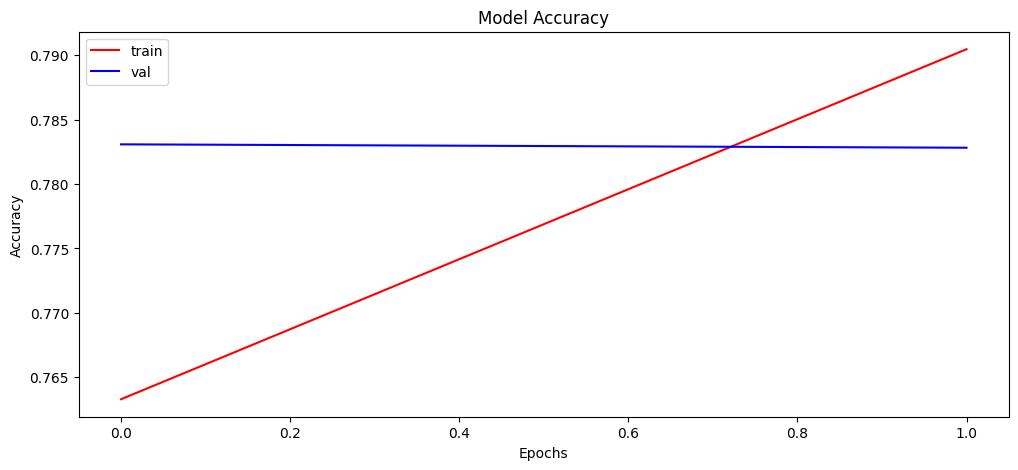

In [44]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['acc'], color='r')
plt.plot(history.history['val_acc'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

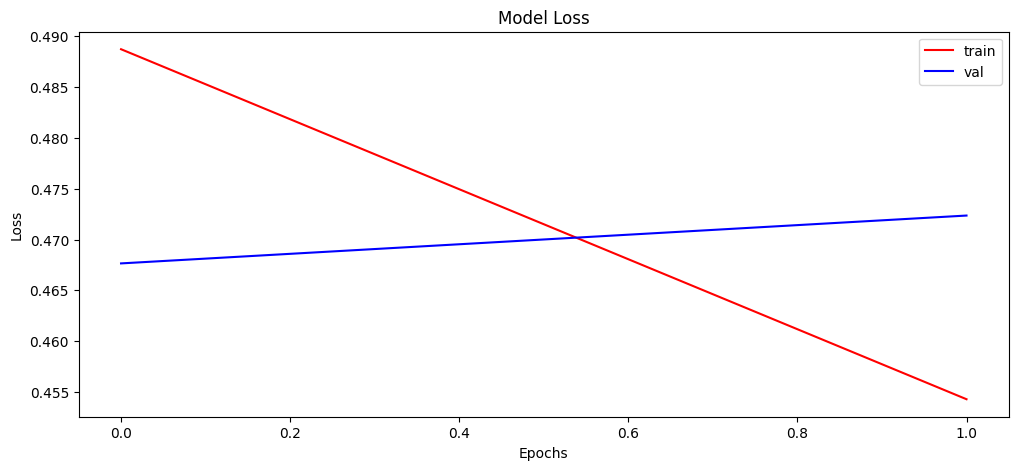

In [45]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [46]:
text = 'Had a wonderful interaction with youngsters from the gaming community... You would love to watch this!'
processed_text = preprocess_apply(text)
processed_text

'had a wonderful interaction with youngsters from the gaming community   you would love to watch this '

In [47]:
texts = []
texts.append(processed_text)
processed_corpus = processCorpus(texts,language)
processed_corpus

['wonderful interaction youngster gaming community would love watch']

In [48]:
tokenized_proccesed_corpus = [sentence.split() for sentence in processed_corpus]
tokenized_proccesed_corpus

[['wonderful',
  'interaction',
  'youngster',
  'gaming',
  'community',
  'would',
  'love',
  'watch']]

In [65]:
text = 'Had a wonderful interaction with youngsters from the gaming community... You would love to watch this!'

processed_text = preprocess_apply(text)

# Process the preprocessed text
texts = []
texts.append(processed_text)
processed_corpus = processCorpus(texts, language)
tokenized_processed_corpus = [sentence.split() for sentence in processed_corpus]

# Tokenize the processed text
processed_sequences = token.texts_to_sequences(tokenized_processed_corpus)

# Pad sequences
padded_processed_sequences = pad_sequences(processed_sequences, maxlen=max_sequence_length)

# Load your model
model = tf.keras.models.load_model('/Users/sruthipg/Documents/Twitter/CA_2/keras_model.h5')

# Predict sentiment
sentiment_prediction = model.predict(padded_processed_sequences)

# Output sentiment prediction
print(sentiment_prediction)

1/1 [==============================] - 0s 268ms/step
[[0.00995657 0.9900434 ]]


In [66]:
predicted_sentiment = 0 if sentiment_prediction[0][0] > sentiment_prediction[0][1] else 1
predicted_sentiment

1

In [69]:
text = "It's hard to forget someone who gave you so much to remember"

processed_text = preprocess_apply(text)

# Process the preprocessed text
texts = []
texts.append(processed_text)
processed_corpus = processCorpus(texts, language)
tokenized_processed_corpus = [sentence.split() for sentence in processed_corpus]

# Tokenize the processed text
processed_sequences = token.texts_to_sequences(tokenized_processed_corpus)

# Pad sequences
padded_processed_sequences = pad_sequences(processed_sequences, maxlen=max_sequence_length)

# Load your model
model = tf.keras.models.load_model('/Users/sruthipg/Documents/Twitter/CA_2/keras_model.h5')

# Predict sentiment
sentiment_prediction = model.predict(padded_processed_sequences)

# Output sentiment prediction
print(sentiment_prediction)
# [[0.37782964 0.6221703 ]

1/1 [==============================] - 0s 98ms/step
[[0.69769263 0.30230737]]


In [70]:
predicted_sentiment = 0 if sentiment_prediction[0][0] > sentiment_prediction[0][1] else 1
predicted_sentiment

0

In [71]:
import pickle

In [72]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)